### Leerdoelen
- Je leert een Business Understanding te formuleren bij een opdrachtgever en een gegeven dataset. 
- Je leert hoe je met Naive Bayes classificatie kan doen op een dataset
- Je leert hoe je tekst data kan voorbewerken via een Bag-of-Words aanpak voordat je het met Naive Bayes gebruikt
- Je leert figuren in je Data Understanding goed in context uit te leggen
- Je leert je conslusies uit het Data Understanding te verbinden aan de uitkomst van je Naive Bayes classifier
- Je leert een keuze tussen Naive Bayes modellen van toenemende complexiteit

### Achtergrondinformatie:
- Google naar:
    - `python naive bayes`
    - `python pandas read fixed width format`
    - `python naive bayes text classification`
    - `python sklearn generate word counts`
    - `python sklearn CountVectorizer`
    - `python bag of words`
- Datacamp course `Machine Learning with Tree-Based Models in Python` -> `Classification and Regression Trees`

### Opdracht 
- Vul het onderstaande notebook aan op de gevraagde plekken. 

# Business Understanding
Spam [was en is](https://www.propellercrm.com/blog/email-spam-statistics) een enorm probleem: 45% van de mails in de wereld is spam, en dit kost het bedrijfsleven rond de 20 miljard dollar per jaar. Om de impact van spam te verlagen is het van groot belang dat we goede spamfilters hebben die er voor zorgen dan mensen spam niet in hun mailbox ontvangen. 

# Data Understanding
Wij gaan ons spamfilter trainen op [een set aan SMS'jes](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/), welke aangeleverd werd als een fixed-width data file:

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd

spam_sms = pd.read_fwf('sms_data.txt',
                       widths=(4, 60), 
                       header=None)
spam_sms.columns = ['spam_or_ham', 'text']
spam_sms.head()

,spam_or_ham,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
spam_sms.describe()

,spam_or_ham,text
count,5574,5574
unique,2,5072
top,ham,"Sorry, I'll call later"
freq,4827,30


De data bestaat uit twee kolommen: `spam_or_ham` geeft aan of het SMS'je wel of niet spam is, en `text` geeft de concrete text van het SMS'je. Hier vormt `spam_or_ham` het label wat we straks voor training gaan gebruiken (naive bayes is dus supervised learning). 

Soms komen sms'jes meerdere keren voor in de dataset:

In [6]:
spam_sms['text'].value_counts().head(10)

text
Sorry, I'll call later                                          30
I cant pick the phone right now. Pls send a message             12
Ok...                                                           10
URGENT! We are trying to contact U. Todays draw shows that       7
Ur cash-balance is currently 500 pounds - to maximize ur ca      6
PRIVATE! Your 2003 Account Statement for shows 800 un-redee      6
URGENT! Your Mobile number has been awarded with a £2000 pr      5
Sad story of a Man - Last week was my b'day. My Wife did'nt      5
Beautiful Truth against Gravity.. Read carefully: "Our heart     4
Sunshine Quiz Wkly Q! Win a top Sony DVD player if u know w      4
Name: count, dtype: int64

Zo op het eerste gezicht zijn de eerste paar een aantal berichten die mensen veel sturen. Na de top 3 lijken het voornamelijke spam sms'jes te zijn. 

# Data preparation
De ruwe text is niet de input voor het model, we zetten deze eerst om naar een [term-document matrix](https://www.displayr.com/text-analysis-hooking-up-your-term-document-matrix-to-custom-r-code/). Deze geeft voor veel voorkomende woorden (terms) over de SMS'jes heen, per SMS'je of dit woord aanwezig is (0, 1). Deze aanpak is een voorbeeld van een [Bag-of-words](https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/) aanpak: de tekst wordt een zak met woorden waar de volgorde van de woorden niet van belang is. 

Wij gebruiken [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) uit sklearn om dit voor ons te doen:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=100, stop_words='english')
term_document = vectorizer.fit_transform(spam_sms['text'])
print(vectorizer.get_feature_names()) # 10 voorbeelden van woorden
term_doc_matrix = term_document.toarray() 
term_doc_matrix

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

Belangrijk hier is dat we alleen de 100 meest voorkomende woorden in de term-document matrix stoppen en dat we [stopwoorden](https://www.quora.com/What-are-stop-words-in-text-analysis) verwijderen.  

Om een eerste inschatting te maken van of de term-document matrix voorspellende kracht heeft maken we het volgende figuur:

              ok  just   ur   ll  got  know  good   lt  come   gt  ...  yup  \
spam_or_ham                                                        ...        
ham          256   224  154  199  183   161   168  176   174  163  ...   41   
spam           3    28   94    3    4    22     9    0     1    0  ...    0   

             leave  cool  man  coming  nice  thk  txt  miss  meeting  
spam_or_ham                                                           
ham             40    38   37      39    39   39    6    38       38  
spam             0     2    2       0     0    0   33     1        0  

[2 rows x 100 columns]


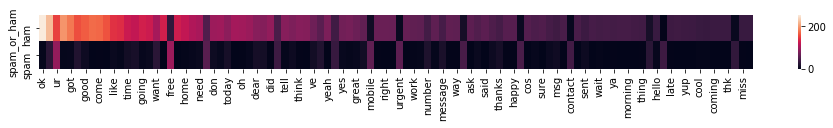

In [5]:
feature_df = pd.concat([spam_sms['spam_or_ham'], 
                        pd.DataFrame(term_doc_matrix, 
                                     columns=vectorizer.get_feature_names())], 
                       axis=1)

import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(16,1))
summed_wordcount_per_spam_ham = feature_df.groupby('spam_or_ham').sum()  # Hoe vaak komt een woord voor in spam of ham
summed_wordcount_all = summed_wordcount_per_spam_ham.sum().sort_values(ascending=False) # Hoe vaak komt een woord in totaal voor
# Sorteer voorkomen spam/ham op totaal voorkomen. Dit is puur voor het plotje zodat de woorden van links naar rechts
# van veel naar weinig voorkomend zijn. 
summed_wordcount_per_spam_ham = summed_wordcount_per_spam_ham.reindex(columns=summed_wordcount_all.index)
print(summed_wordcount_per_spam_ham)
sn.heatmap(summed_wordcount_per_spam_ham)

Op de x-as zien we hier de verschillende woorden, of de y-as of het spam of ham is, en de kleur geeft het totaal aantal keer dat dit woord voorkomt. De woorden zijn gesorteerd van links (meest voorkomend woord) naar rechts (minst voorkomend woord). 

Uit dit figuur is duidelijk dat er:
- Woorden zijn die veel voorkomen in `ham` messages maar niet in `spam` messages (like, time, going). 
- Woorden zijn die veel voorkomen in `spam` maar niet in `ham` messages (won, reply)
- Er zijn veel meer `ham` specifieke woorden dan `spam` specifieke woorden

Over het algemeen lijkt er wel verschil te zijn tussen spam en ham messages, wat ons positief stemt over de mogelijkheid dat Naive Bayes het verschil tussen spam en ham messages kan zien. 

# Modeling

## Model met 100 woorden
Nu de data klaar staat gaan we de term-document matrix gebruiken om een Naive Bayes modellen te voeden. 

0.4309618173208557


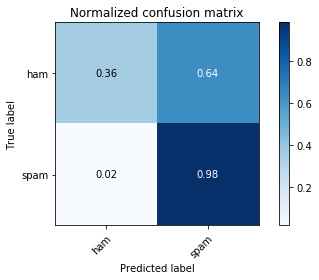

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split 
from helper_functions import plot_confusion_matrix
from sklearn.metrics import f1_score

indep_var = term_doc_matrix
dep_var = spam_sms['spam_or_ham']
indep_var_train, indep_var_test, dep_var_train, dep_var_test = train_test_split(indep_var, dep_var, test_size=0.3)

spam_model = GaussianNB().fit(indep_var_train, dep_var_train)
print(f1_score(dep_var_test, spam_model.predict(indep_var_test), average='macro'))
plot_confusion_matrix(dep_var_test, spam_model.predict(indep_var_test), ['ham', 'spam'], normalize=True)

Hier uit blijkt dat dit model:

- Goed is in het detecteren van spam (99% accurate)
- Erg veel niet-spam onterecht als spam aanduid, maar 36% van de ham wordt correct geclassificeerd.
- Samen leidt dit tot een vrij matig model met een [f1 score](https://en.wikipedia.org/wiki/F1_score) van 0.42

## Model met 1000 woorden
Om het model beter te maken gaan we meer woorden in de term-documen matrix stoppen zodat ze mee kunnen gaan in het model:

0.7038825745603499


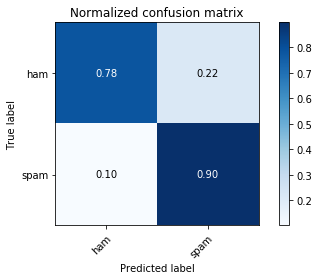

In [7]:
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
term_document = vectorizer.fit_transform(spam_sms['text'])
term_doc_matrix = term_document.toarray() 

indep_var = term_document.toarray()
dep_var = spam_sms['spam_or_ham']
indep_var_train, indep_var_test, dep_var_train, dep_var_test = train_test_split(indep_var, dep_var, test_size=0.3)

spam_model = GaussianNB().fit(indep_var_train, dep_var_train)
print(f1_score(dep_var_test, spam_model.predict(indep_var_test), average='macro'))
plot_confusion_matrix(dep_var_test, spam_model.predict(indep_var_test), ['ham', 'spam'], normalize=True)

Dit model wordt al een stuk beter met een f1 score van ongeveer 0.75. Dit komt voornamelijk doordat het model beter is geworden in het correct voorspellen van `ham`: nu wordt 80% van de ham goed geclassificeerd tov 36% eerst. 

## Verband tussen aantal woorden en model performance
We zien dat het ophogen van het aantal woorden van 100 naar 300 een beter resultaat oplevert. Maar waar ligt de grens? De volgende analyse verkent de performance van het model tussen de 1 en 2000 woorden:

..

C:\Users\PH0110357\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


..................................................................................................

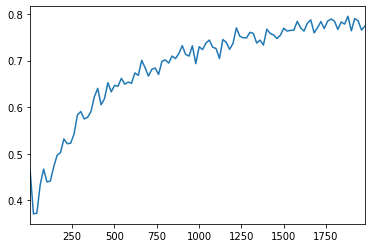

In [8]:
def get_accuracy_per_max_feature(max_feature, print_confusion=False):
    print('.', end='')
    vectorizer = CountVectorizer(max_features=max_feature, stop_words='english')
    res = vectorizer.fit_transform(spam_sms['text'])
    
    indep_var = res.toarray()
    dep_var = spam_sms['spam_or_ham']
    indep_var_train, indep_var_test, dep_var_train, dep_var_test = train_test_split(indep_var, dep_var, test_size=0.3)
    spam_model = GaussianNB().fit(indep_var_train, dep_var_train)
    if print_confusion:
        plot_confusion_matrix(dep_var_test, spam_model.predict(indep_var_test), ['ham', 'spam'], normalize=True)
    return f1_score(dep_var_test, spam_model.predict(indep_var_test), average='macro')

test_max_features = np.arange(1,2000,20)
pd.Series([get_accuracy_per_max_feature(mxft) for mxft in test_max_features], index=test_max_features).plot()

Hieruit blijkt duidelijk dat de performance langzamerhand beter wordt tussen de 1 en 2000 woorden. Wel vlakt de performance af rond de f1 score van 0.8. De optimale hoeveelheid woorden lijkt rond de 1750 te liggen. 

Als we kijken naar de confusion matrix van 1750 woorden:

.

0.7795191987308597

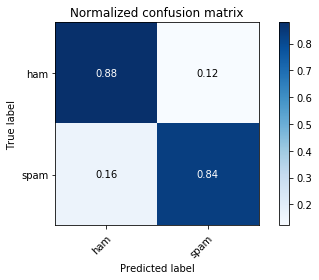

In [9]:
get_accuracy_per_max_feature(1750, print_confusion=True)

Zien dat we het overall veel beter doen dan het 300 woorden document. Deze verbetering zit hem voornamelijk in dat we beter zijn geworden in het onderscheiden van wat normale mail is, hier is de score verbeterd van ong 40% naar rond de 10%. Wel hebben we hiervoor een prijs betaald: het aantal keer dat we onterecht iets als ham aanduiden is veel hoger geworden (5-16%). 

# Evaluation
Het model wat we gebouwt hebben is een mooie eerste opzet voor een spam model. Wel zal het model nog veel beter moeten gaan presteren voordat het echt nuttig wordt. Op dit moment wordt nog rond de 20% van de mails fout geclassificeerd, zowel onterecht spam als onterecht ham. Nog meer en slimmere features bouwen zal ons deze performance moeten opleveren, bijvoorbeeld:

- lengte van de SMS
- Voorkomen van letters
- [Andere maten](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) gebruiken die zich meer richten op woorden die veel voorspellend vermogen hebben 
- [Features bouwen](http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/) die niet alleen naar het voorkomen van woorden kijken, maar ook naar de volgorde en context van de woorden. 